# **Investment Advisor**

## **About the Scenario**

This notebook demonstrates a practical use case where an AI Agent is leveraged to gain actionable insights and address key analytical questions related to managing an investment portfolio. It combines data fetching, computation, and visualization to streamline decision-making.

The scenario utilizes an AI Agent integrated with two powerful tools: Function Calling and Code Interpreter. These tools work together to retrieve stock prices and calculate portfolio metrics, replicating real-world workflows in investment management.

### Key Steps:

1. *Upload Investment Data*: Import a CSV file containing the user’s investment portfolio into the OpenAI Project.
2. *Fetch Real-Time Stock Prices*: Use the Yahoo! Finance API via *Function Calling* to retrieve up-to-date closing stock data.
3. *Perform Portfolio Analysis*: Leverage *Code Interpreter* to compute key portfolio metrics and insights.
4. *Create Data Visualations*: Leverage *Color Interpreter* to generate portfolio visualization, and leverage Python libraries to render image.

## **Data**
This scenario uses files from the folder [`data/`](./data/) in this repo. You can clone this repo or copy this folder to make sure you have access to these files when running the sample.

## **Time**
You should expect to spend 10-15 minutes building and running this scenario. 

## **Before you begin**

#### Step 1: Install required libraries
Install dependencies directly within a Jupyter notebook is a good practice because it ensures that all required packages are installed in the correct versions, making the notebook self-contained and reproducible. This approach helps other users or collaborators to set up the environment quickly and avoid potential issues related to missing or incompatible packages.

In [64]:
# Install the packages
%pip install -r ./requirements.txt

Processing c:\developer\repos\github\azure-ai-agents\packages\azure_ai_projects-1.0.0b1-py3-none-any.whl (from -r ./requirements.txt (line 7))
azure-ai-projects is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Note: you may need to restart the kernel to use updated packages.


#### Step 2: Setting up the environment
Before we begin, we need to load the necessary environment variables from a `.env` file. These variables include sensitive information such as API keys and endpoint URLs, which are crucial for running the code successfully.

Here’s what you need to do:
- Ensure your `.env` file is properly configured in the `.venv/.env` format. We have provided an template `.env` file, `.env.example` for your reference.
- Verify that all required secrets are included in the file before running the code.


The `.env` file must contain the following secrets:
- PROJECT_CONNECTION_STRING: URL to connect to the Azure OpenAI Project to access project resources.
- AZURE_OPENAI_DEPLOYMENT: The name of the Azure OpenAI model deployment.

Now, let’s load these variables and get started!

<code style="background:yellow;color:black">Note: Make sure to keep your `.env` file secure and avoid sharing it publicly. </code>

*For more information about leveraging Python Virtual Environments can be found [here](https://docs.python.org/3/library/venv.html).*

In [65]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Retrieve the secrets
__PROJECT_CONNECTION_STRING = os.getenv("PROJECT_CONNECTION_STRING")
__AZURE_OPENAI_DEPLOYMENT = os.getenv("AZURE_OPENAI_DEPLOYMENT")

# Verify environment variables
if not all([__PROJECT_CONNECTION_STRING, __AZURE_OPENAI_DEPLOYMENT]):
    raise EnvironmentError("One or more environment variables are missing. Please check the .env file.")
else:
    print("Environment variables loaded successfully.")

Environment variables loaded successfully.


## **Azure Agent Runtime setup**

#### Step 1: Initializing the Azure Agent Runtime Client

Next, we’ll initialize the Azure Agent Runtime client. This client allows us to interact with Azure OpenAI Project Agents. We will use a `DefaultAzureCredential` to authenticate, meaning you will have to be logged in with the Azure CLI.

In [66]:
import os
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

# Initialize the Azure AI Project client
project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(),
    conn_str=os.environ["PROJECT_CONNECTION_STRING"],
)

agents_client = project_client.agents

print("Agent client created successfully.")

Agent client created successfully.


#### Step 2: Upload supporting file to Azure OpenAI deployment

Now, we'll upload the `investment_portfolio.csv` file from the `\data` directory to Azure OpenAI, ensuring any existing `investment_portfolio.csv` is removed beforehand to ensure the latest version of the file is used and no duplicates exist. This process will handle the entire upload. The file is necessary for this scenario, but its contents can be modified as long as the file structure remains unchanged. The file schema must be as followed:

- Symbol
- Average_Cost
- QTY

In [67]:
# Directory containing files to upload
directory="data"
portfolio_file="investment_portfolio.csv"
portfolio_file_id=None

# Check if the directory exists
if not os.path.isdir(directory):
    print(f"Directory '{directory}' does not exist.")
    raise FileNotFoundError(f"Directory '{directory}' does not exist.")

file_path = os.path.join(directory, portfolio_file)

# Check if the file exists
if not os.path.isfile(file_path):
    print(f"Skipping non-file item: {portfolio_file}")

try:
    # Delete existing file on Azure if it has the same name and purpose
    existing_files = agents_client.list_files()
    for f in existing_files.data:
        if f.filename == portfolio_file and f.purpose == "assistants":
            agents_client.delete_file(f.id)
            print(f"Deleted existing file: {portfolio_file}")

    # Upload new file
    with open(file_path, "rb") as file_data:
        file = agents_client.upload_file(file=file_data, purpose="assistants")
        portfolio_file_id = file.id
    print(f"Uploaded file: {portfolio_file}")
except Exception as e:
    print(f"Error processing file '{portfolio_file}': {e}")

Deleted existing file: investment_portfolio.csv
Uploaded file: investment_portfolio.csv


## **Azure OpenAI Agent**

### Step 1: Define function for Agent Function Calling tool
In this scenario, we will utilize the *Function Calling* tool within the Agent to enhance our insights by invoking a custom function. Since the LLM and Agent currently lack direct access to the internet for user prompts, *Function Calling* serves as a powerful alternative.

We will use the `fetch_stock_price` function to retrieve stock data for a specified *ticker symbol*. This function leverages the `yfinance` library to fetch the most recent stock price data, specifically for the last trading day.

This approach enables the Agent to provide up-to-date, actionable insights by integrating external data sources through custom functions. 

Let’s explore how to implement and use this functionality!

In [68]:
import yfinance as yf

def fetch_stock_price(ticker_symbol: str) -> str:
    """
    Fetch the latest stock price for a given ticker symbol.

    Parameters:
    - ticker_symbol (str): The ticker symbol of the stock to retrieve data for.

    Returns:
    - str: The closing price of the stock for the latest trading day, or an error message if data is unavailable.

    Example:
    >>> fetch_stock_price("AAPL")
    "148.9"
    """
    
    try:
        # Fetch the stock's trading history for the last day
        stock = yf.Ticker(ticker_symbol)
        stock_data = stock.history(period="1d")

        # Check if the data is empty, indicating an invalid ticker or no data available
        if stock_data.empty:
            return f"Error: No data found for ticker symbol: {ticker_symbol}"

        # Retrieve and return the latest closing price
        latest_close_price = stock_data['Close'].iloc[-1]
        return str(round(latest_close_price, 3))

    except KeyError as e:
        return f"Error: Data missing for key: {e}. Verify the ticker symbol."

    except Exception as e:
        return f"Error: Unexpected issue occurred - {type(e).__name__}: {e}"
    
print("Function defined successfully.")

Function defined successfully.


We define a dictionary, `available_functions`, to map function names to their respective implementations, such as `fetch_stock_price`. This structure is designed to support scalability, allowing easy addition of multiple callable functions to expand your solution.

In [69]:
available_functions = {"fetch_stock_price": fetch_stock_price}

### Step 2: Configure Agent Tool-Calling for Enhanced Functionality
The tool-calling definition informs the LLM about the tools available for its use. In our scenario, this configuration enables both *code interpretation* and *function calling*.

We will specifically configure the `fetch_stock_price` function alongside the *code interpreter tool*. By integrating this tool into the Agent, we empower it to:

- Retrieve stock data for a specified ticker symbol using the `fetch_stock_price` function.
- Interpret and analyze the retrieved data to provide meaningful insights in response to user queries.

This setup allows the Agent to seamlessly combine external data retrieval with code-based reasoning, ensuring accurate and actionable responses to stock-related prompts. 

Let’s define and integrate this tool to unlock its full potential!

In [70]:
tools_list = [
    {"type": "code_interpreter"},
    {
        "type": "function",
        "function": {
            "name": "fetch_stock_price",
            "description": "Retrieve the latest closing price of a stock using its ticker symbol.",
            "parameters": {
                "type": "object",
                "properties": {"ticker_symbol": {"type": "string", "description": "The ticker symbol of the stock"}},
                "required": ["ticker_symbol"],
            },
        },
    }
]

print("Tools list defined successfully.")

Tools list defined successfully.


### Step 3:  Creating an Investment Analysis Agent
In this step, we’ll set up an Azure OpenAI Agent with the specified tools to handle investment-related queries. This Agent will also leverage the previously defined function calls to provide accurate and actionable insights. 

Let’s configure the Agent and enable its capabilities! 

In [71]:
# Create the Agent with code interpreter and function calling tools enabled
try:
    agent = agents_client.create_agent(
        name="Investment Advisor Agent",
        instructions=(
            "You are an expert investment analyst. "
            "Use your knowledge base to answer questions about personal investment portfolio management."
        ),
        model=__AZURE_OPENAI_DEPLOYMENT,
        tools=tools_list
    )
    print("Agent created successfully.\n", agent.id)
except Exception as e:
    print("Error creating Agent:", e)

Agent created successfully.
 asst_DrCppIg6J2qV3pDLx2Ec3VWp


### Step 4: Starting a New Conversation Thread
Let’s create a new thread to handle user interactions. Each thread provides a dedicated space for conversations with the Agent, keeping the context focused and organized. 

This setup ensures clear and seamless communication for each user interaction.

In [72]:
# Create a conversation thread
try:
    thread = agents_client.create_thread()
    print("Thread created successfully:", thread.id)
except Exception as e:
    print("Error creating thread:", e)

Thread created successfully: thread_tJFrlqwuXbCT79Axb9E0SEl0


## **Demonstrating the Thread Run Process (Manual)**

The next six cells will demonstrate how the Agent's thread run process works. Instead of running a typical loop with a polling mechanism to monitor the run status, we’ll manually step through the cells to better understand each stage of the process.

In the subsequent section, these cells will be wrapped into a processing function to expand the functionality by incorporating polling and different completion content type, providing a more streamlined and automated workflow. This approach helps clarify how the thread execution operates while offering a hands-on view of each step.

### Step 1: Adding User Message to the Thread
In this step, we’ll add a user message to the thread to demonstrate the Agent’s capabilities. Specifically, we’ll ask for the latest closing price of a specified company (*Microsoft*), which will leverage *function calling* to retrieve this data using the `fetch_stock_price` function.

The Agent will then use the *code interpreter* to combine this information with the `QTY` data from the uploaded `investment_portfolio.csv` file to calculate the **total investment**. 

This workflow showcases how the Agent integrates external data retrieval with computational analysis to deliver actionable insights.

In [74]:
# Define the user question
prompt_content = "What is the latest closing price for Microsoft? What is my total investment for MSFT as of today?"

# Add the question to the thread
try:
    message = agents_client.create_message(
        thread_id=thread.id,
        role="user",
        content=prompt_content,
        attachments=[  # Add files by using the attachments parameter
            {"file_id": portfolio_file_id, "tools": [{"type": "code_interpreter"}]}
        ],
    )
    print("Successfully added User prompt to the thread.\n", message.id)
except Exception as e:
    print("Error adding user question:", e)


Successfully added User prompt to the thread.
 msg_OA2BNixqKJ6aqPQGTlS9OoVi


### Step 2: Running the Agent
Now that the Agent and thread are set up, we'll initiate the Agent's response process. This will analyze the user prompt and provide insights based on the investment portfolio data.


In [75]:
# Initiate the Agent's response
try:
    run = agents_client.create_run(
        thread_id=thread.id,
        assistant_id=agent.id,
        instructions=prompt_content,
    )
    print("Run started:", run.id)
except Exception as e:
    print("Error starting run:", e)

Run started: run_tqp6osVT8klJzYvvxW4KVkSU


### Step 3: Monitor run status

A Run is an instance where an Agent operates within a Thread. During a Run, the Agent processes the Thread's Messages and its configuration to perform tasks using models and tools, adding additional Messages to the Thread as part of its operations.

The Agent might take some time to analyze and respond, so it's important to monitor the run status. Based on the status, *specific actions are executed*. 

Let's dive deeper into these status-driven actions!

In [79]:
import json

# Retrieve the run status
run = agents_client.get_run(
    thread_id=thread.id,
    run_id=run.id
)
#print(run.model_dump_json(indent=4))

if run.status in ('queued', 'in_progress'):
    print(f"Run this cell again to monitor the status.\nCurrent Status: {run.status}")
else:
    print(f"Monitoring the run status...\nNavigate to `{run.status}` cell.")

Monitoring the run status...
Navigate to `RunStatus.COMPLETED` cell.


#### Step 4a: Failed status

If the status is `failed` we will print the error message with relevant information to aid in troubleshooting.

In [77]:
#print(run.model_dump_json(indent=4))

if run.status == "failed":
    print("Agent run failed. Please try again.")
    print(run)
else:
    print(f"Agent run has not failed...\nNavigate to and execute the '{run.status}' cell.")


Agent run has not failed...
Navigate to and execute the 'RunStatus.REQUIRES_ACTION' cell.


#### Step 4b: Requires Action status

If the status is `requires_action`, first we need to check if the required action is to submit tool outputs and iterate over the tool calls, ensuring that the requested function exists in the available_functions dictionary. If the function exists, it is called with the provided arguments, and the response is stored. After processing all tool calls, we submit the tool outputs back to the OpenAI client.

In [78]:
if run.status == "requires_action":
    print("Function Calling ...")
    tool_responses = []
    if (
        run.required_action.type == "submit_tool_outputs"
        and run.required_action.submit_tool_outputs.tool_calls is not None
    ):
        tool_calls = run.required_action.submit_tool_outputs.tool_calls

        for call in tool_calls:
            if call.type == "function":
                if call.function.name not in available_functions:
                    raise Exception("Function requested by the model does not exist")
                function_to_call = available_functions[call.function.name]
                tool_response = function_to_call(**json.loads(call.function.arguments))
                tool_responses.append({"tool_call_id": call.id, "output": tool_response})
                print(f"Function '{call.function.name}' called successfully. \nOutput: {tool_response}\n")

    run = agents_client.submit_tool_outputs_to_run(
        thread_id=thread.id, run_id=run.id, tool_outputs=tool_responses
    )

    print(f"Results submitted successfully. Go back to the first cell, 'Monitor Run Status' and execute again.")
else:
    print(f"Navigate to and execute the {run.status} cell.")

Function Calling ...
Function 'fetch_stock_price' called successfully. 
Output: 415.69

Results submitted successfully. Go back to the first cell, 'Monitor Run Status' and execute again.


#### Step 4c: Completed status

If the status is `completed`, we will fetch and print all messages in the thread, displaying the role and content of each message.The messages are printed in reverse order because messages in a thread are in FILO (First-In-Last-Out) order and in order to make the messages more conversational for ease of user reading, we must reverse the order.

In [80]:
if run.status == "completed":
    messages = agents_client.list_messages(thread_id=thread.id, order="asc", after=message.id)

    print(f'Run completed!\n\nMESSAGES\n')

    # Loop through messages and print content based on role
    for msg in messages.data:
        role = msg.role
        content = msg.content[0].text.value
        print(f"{role.capitalize()}: {content}")

else:
    print(f"Navigate to and execute the {run.status} cell.")

Run completed!

MESSAGES

Assistant: The latest closing price for Microsoft (MSFT) is $415.69.

Next, I'll check the uploaded file to determine your total investment in MSFT as of today. Let's take a look at the contents of the file first.
Assistant: According to the uploaded file, you have the following investment details for Microsoft (MSFT):

- Symbol: MSFT
- Average Cost: $200
- Quantity: 300 shares

To determine your total investment for MSFT as of today:

1. Multiply the quantity of MSFT shares by the latest closing price.
2. Calculate the total investment value.

Let's calculate that.
Assistant: Your total investment for Microsoft (MSFT) as of today is $124,707.00.


## **Refining the Process**

### Step 1: Wrapping the Thread Run Process into a Function
In this section we will refine the manual approach and encapsulate the thread run process into a single  function. This function automates the steps demonstrated in the previous cells by including the polling functionality to monitor the run status.

By wrapping the process into a reusable function, we streamline the workflow and ensure that the thread execution is both efficient and easy to integrate into broader applications. The function also expands the functionality for handling different completion content types, such as image rendering.

Let’s implement this functionality!

In [81]:
import time
import json
import matplotlib.pyplot as plt
from PIL import Image

available_functions = {"fetch_stock_price": fetch_stock_price}

def process_message(thread_id, prompt_message, attachments_list=None):
    try:
        # Add the prompt to the thread
        message = agents_client.create_message(
            thread_id=thread_id,
            role="user",
            content=prompt_message,
            attachments=attachments_list,
        )
        print("User message added...") #:", message)

        # Initiate the Agent's response
        run = agents_client.create_run(
            thread_id=thread_id,
            assistant_id=agent.id,
            instructions=prompt_message,
        )
        print("Run started...") #:", run)
    except Exception as e:
        print("Error starting run:", e)

    while True:  # Polling to monitor Run status
        time.sleep(5)  # Wait 5 seconds to give the process time to move past `queued` state

        # Retrieves the thread’s response.
        run = agents_client.get_run(
            thread_id=thread_id,
            run_id=run.id
        )

        run_status = run.status
        print(f"Run Status: {run_status}\n")
        if run_status == 'completed':
            # Get all messages in thread to read
            thread_messages = agents_client.list_messages(thread_id=thread_id, order="asc") #, after=message.id)

            # Loop through thread messages and print content
            for thread_message in thread_messages.data:
                role = thread_message.role
                content = None
                if isinstance(thread_message.content, list) and thread_message.content:
                    first_content = thread_message.content[0]

                    # handle text
                    if hasattr(first_content, "text") and hasattr(first_content.text, "value"):
                        content = first_content.text.value

                    # handle image file
                    elif hasattr(first_content, "image_file"):
                        
                        # Download the file locally
                        file_content = agents_client.get_file_content(first_content.image_file.file_id)

                        # Delete existing file locally if it has the same name
                        if os.path.exists("./data/sample_chart.png"):
                            os.remove("./data/sample_chart.png")
                            print("Deleted existing file: ./data/sample_chart.png")
                            
                        with open("./data/sample_chart.png", "wb") as f:
                            for chunk in file_content:  
                                f.write(chunk)
                        print("Image File downloaded to './data' successfully.")

                        # Display the image using Pillow and Matplotlib
                        img = Image.open("./data/sample_chart.png")
                        plt.imshow(img)
                        plt.axis('off')
                        plt.show()
                    
                    else:
                        content = str(first_content)
                else:
                    content = str(thread_message.content)

                print(f"{role.capitalize()}: {content}")
            
            break
        elif run.status == "failed":
            messages = agents_client.list_messages(thread_id=thread.id)
            answer = messages.data[0].content[0].text.value
            print(f"Failed User:\n{prompt_message}\nAgent:\n{answer}\n")

            # Handle failed
            break

        elif run.status == "requires_action" and run.required_action.type == "submit_tool_outputs":
            print("Function calling initiated...")
            tool_calls = run.required_action.submit_tool_outputs.tool_calls
            tool_responses = []
            
            # Iterate over each function call requested by the Agent
            for call in tool_calls:
                # Check if the call is a function and if the function exists is our custom function
                if call.type == "function" and call.function.name in available_functions:
                    func = available_functions[call.function.name]  # Retrieve the function reference
                    
                    # Parse the function arguments from JSON and execute the function
                    tool_response = func(**json.loads(call.function.arguments))
                    
                    # Store the tool call ID and output to later send back to the Agent
                    tool_responses.append({"tool_call_id": call.id, "output": tool_response})
                    print(f"Executed '{call.function.name}'. Output: {tool_response}")
                
                else:
                    # Raise an error if the function is not in available_functions to handle unexpected requests
                    raise ValueError(f"Requested function '{call.function.name}' is not available.")
            
            # Submit all collected tool outputs back to the Agent to satisfy the required action
            run = agents_client.submit_tool_outputs_to_run(
                thread_id=thread_id, 
                run_id=run.id, 
                tool_outputs=tool_responses
            )
            print("Function call(s) completed successfully.")

        else:
            time.sleep(5)

print("Function `process_message` created successfully.")


Function `process_message` created successfully.


### Step 2a: Basic Message Sample
This sample demonstrates how the Agent uses the standard LLM system to answer the query: *"What is today's date?"* The Agent responds by retrieving the current date directly from its built-in capabilities, without relying on additional tools or attachments.

In [82]:
process_message(thread_id=thread.id, prompt_message="What is today's date?")

User message added...
Run started...
Run Status: RunStatus.COMPLETED

User: What is the latest closing price for Microsoft? What is my total investment for MSFT as of today?
Assistant: The latest closing price for Microsoft (MSFT) is $415.69.

Next, I'll check the uploaded file to determine your total investment in MSFT as of today. Let's take a look at the contents of the file first.
Assistant: According to the uploaded file, you have the following investment details for Microsoft (MSFT):

- Symbol: MSFT
- Average Cost: $200
- Quantity: 300 shares

To determine your total investment for MSFT as of today:

1. Multiply the quantity of MSFT shares by the latest closing price.
2. Calculate the total investment value.

Let's calculate that.
Assistant: Your total investment for Microsoft (MSFT) as of today is $124,707.00.
User: What is today's date?
Assistant: Today's date is November 18, 2024.


### Step 2b: Code Interpreter Sample
This sample demonstrates the use of *Code Interpreter* to analyze an uploaded portfolio file and answer the query: "What stock do I have the most investment in?". The Code Interpreter analyzes the file to identify the stock with the highest investment and provides the result, showcasing its ability to integrate data analysis seamlessly into the conversation.

In [83]:
attachments=[  # Add files by using the attachments parameter
            {"file_id": portfolio_file_id, "tools": [{"type": "code_interpreter"}]}
        ]

process_message(thread_id=thread.id, prompt_message="Which company have I invested in the most?", attachments_list=attachments)

User message added...
Run started...
Run Status: RunStatus.REQUIRES_ACTION

Function calling initiated...
Executed 'fetch_stock_price'. Output: 229.075
Executed 'fetch_stock_price'. Output: 202.0
Executed 'fetch_stock_price'. Output: 338.36
Executed 'fetch_stock_price'. Output: 841.705
Function call(s) completed successfully.
Run Status: RunStatus.IN_PROGRESS

Run Status: RunStatus.COMPLETED

User: What is the latest closing price for Microsoft? What is my total investment for MSFT as of today?
Assistant: The latest closing price for Microsoft (MSFT) is $415.69.

Next, I'll check the uploaded file to determine your total investment in MSFT as of today. Let's take a look at the contents of the file first.
Assistant: According to the uploaded file, you have the following investment details for Microsoft (MSFT):

- Symbol: MSFT
- Average Cost: $200
- Quantity: 300 shares

To determine your total investment for MSFT as of today:

1. Multiply the quantity of MSFT shares by the latest closin

### Step 2c: Function Calling Sample
This sample demonstrates how the Agent utilizes the *Function Calling* tool to answer the query: *"What is the current stock price for Amazon?"*. The Agent invokes the previously defined `fetch_stock_price` function to retrieve the latest stock price for Amazon, showcasing how the Function Calling tool integrates external data retrieval into the Agent's workflow.

In [84]:
process_message(thread_id=thread.id, prompt_message="What is the current stock price for Amazon? Based on this price, what is the total investment value for AMZN?")

User message added...
Run started...
Run Status: RunStatus.COMPLETED

User: What is the latest closing price for Microsoft? What is my total investment for MSFT as of today?
Assistant: The latest closing price for Microsoft (MSFT) is $415.69.

Next, I'll check the uploaded file to determine your total investment in MSFT as of today. Let's take a look at the contents of the file first.
Assistant: According to the uploaded file, you have the following investment details for Microsoft (MSFT):

- Symbol: MSFT
- Average Cost: $200
- Quantity: 300 shares

To determine your total investment for MSFT as of today:

1. Multiply the quantity of MSFT shares by the latest closing price.
2. Calculate the total investment value.

Let's calculate that.
Assistant: Your total investment for Microsoft (MSFT) as of today is $124,707.00.
User: What is today's date?
Assistant: Today's date is November 18, 2024.
User: Which company have I invested in the most?
Assistant: To determine which company you have i

### Step 2d: Generating and Visualizing Data
This sample shows how an Agent can be used to generate data visualizations, save them locally, and leverage with Python libraries like `Pillow` and `Matplotlib` for rendering. For example, when asked *"Show a pie chart of my investments"*, the Agent analyzes the `investment_portfolio` file using Code Interpreter and creates a downloadable pie chart image.

User message added...
Run started...
Run Status: RunStatus.IN_PROGRESS

Run Status: RunStatus.COMPLETED

User: What is the latest closing price for Microsoft? What is my total investment for MSFT as of today?
Assistant: The latest closing price for Microsoft (MSFT) is $415.69.

Next, I'll check the uploaded file to determine your total investment in MSFT as of today. Let's take a look at the contents of the file first.
Assistant: According to the uploaded file, you have the following investment details for Microsoft (MSFT):

- Symbol: MSFT
- Average Cost: $200
- Quantity: 300 shares

To determine your total investment for MSFT as of today:

1. Multiply the quantity of MSFT shares by the latest closing price.
2. Calculate the total investment value.

Let's calculate that.
Assistant: Your total investment for Microsoft (MSFT) as of today is $124,707.00.
User: What is today's date?
Assistant: Today's date is November 18, 2024.
User: Which company have I invested in the most?
Assistant: To

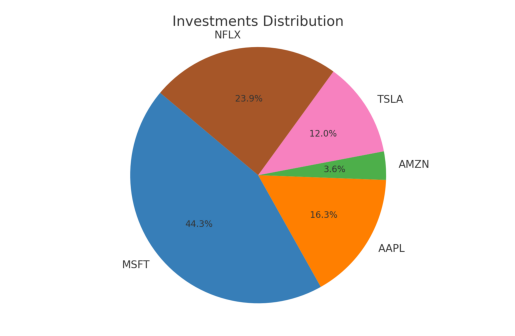

Assistant: None


In [85]:
process_message(thread_id=thread.id, prompt_message="Show a pie chart of my investments? Ensure the pie chart color schema aligns with accessibility standards.")

## **Clean Up**

### Step 1: Delete Agent Resource
To avoid creating redundant resources and ensure a clean environment, this cell deletes the Agent, thread, and any other created resources.


In [101]:
# Get agent list
agents = agents_client.list_agents()

# If the agent exists in the list, delete it
if agent.id in [a.id for a in agents.data]:
    response = agents_client.delete_agent(agent.id)
    print("Deleted Agent Client\n",response)
else:
    print("Agent does not exist to delete.")

Agent does not exist to delete.


### Step 2: Delete File
Deletes the file that was uploaded during the execution of the scenario notebook.

In [105]:
try:
    # Delete existing file on Azure if it has the same name and purpose
    existing_files = agents_client.list_files()
    for f in existing_files.data:
        if f.filename == portfolio_file and f.purpose == "assistants":
            agents_client.delete_file(f.id)
            print(f"Deleted existing file: {portfolio_file}")

except Exception as e:
    print(f"Error processing file '{portfolio_file}': {e}")

## **Wrap Up**
This notebook demonstrated how Generative AI can be leveraged to streamline investment portfolio analysis by automating data retrieval, computation, and insight generation. Key aspects included:

1. *Data Import*:
   - Uploaded and processed a CSV file containing the investment portfolio details.

2. *Real-Time Stock Data Retrieval*:
   - Integrated the Yahoo! Finance API to fetch live stock prices for portfolio assets.

3. *Portfolio Analysis*:
   - Computed key metrics such as total portfolio value, asset-wise allocation, and performance indicators.
   - Derived actionable insights into asset performance and allocation efficiency.

4. *Visualization and Insights*:
   - Presented key findings with graphs and charts for better interpretation.
   - Highlighted trends and potential areas for optimization.

5. *AI Workflow*:
   - Demonstrated how Function Calling and Code Interpreter tools integrate to handle real-world investment management tasks.


## **Next Steps: Expanding Generative AI Applications**

Building on this scenario, the following Generative AI-focused advancements can be pursued:

1. *Interactive Portfolio Management Application*:
   - Develop a web or mobile application powered by Generative AI to provide real-time portfolio insights, visualizations, and recommendations.
   - Integrate conversational interfaces for users to query portfolio performance or simulate investment strategies in natural language.

2. *Enhanced Personalization*:
   - Train models to provide personalized investment advice based on user-defined goals, risk tolerance, and preferences.
   - Implement scenario-based AI recommendations for portfolio rebalancing.

3. *Proactive Alerts and Forecasts*:
   - Use Generative AI to provide alerts for significant market movements or deviations in portfolio performance.
   - Implement predictive models to forecast asset performance or potential market risks.